### Notebook to evaluate test case similarty approaches with F-score

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load ground truth of similar test cases

In [2]:
# Read excel files with manually clustered samples
test_case_sample_df = pd.read_excel('sample_manual_ground_truth/test_case_samples.xlsx')

In [4]:
test_case_system_focus_dict = {}
for index, row in test_case_sample_df.iterrows():
    test_case_key = row['Key']
    if pd.isnull(test_case_key):
        continue
    else:
        test_case_key = test_case_key.replace('[', '').replace(']', '')
    
    system_focus_1 = row['system_focus_1']
    system_focus_2 = row['system_focus_2']
    system_focus_3 = row['system_focus_3']
    system_focus_4 = row['system_focus_4']
    system_focus_5 = row['system_focus_5']
    
    if not pd.isnull(system_focus_1):
        test_case_system_focus_dict[test_case_key] = [system_focus_1.lower()]
        
    if not pd.isnull(system_focus_2):
        existing_list = test_case_system_focus_dict[test_case_key]
        existing_list.append(system_focus_2.lower())
        test_case_system_focus_dict[test_case_key] = existing_list

    if not pd.isnull(system_focus_3):
        existing_list = test_case_system_focus_dict[test_case_key]
        existing_list.append(system_focus_3.lower())
        test_case_system_focus_dict[test_case_key] = existing_list
        
    if not pd.isnull(system_focus_4):
        existing_list = test_case_system_focus_dict[test_case_key]
        existing_list.append(system_focus_4.lower())
        test_case_system_focus_dict[test_case_key] = existing_list
        
    if not pd.isnull(system_focus_5):
        existing_list = test_case_system_focus_dict[test_case_key]
        existing_list.append(system_focus_5.lower())
        test_case_system_focus_dict[test_case_key] = existing_list

In [6]:
test_case_keys_list = list(test_case_system_focus_dict.keys())

In [9]:
overlap_matrix = np.zeros((len(test_case_keys_list), len(test_case_keys_list)))

In [10]:
for i in range(len(test_case_keys_list)):
    for j in range(len(test_case_keys_list)):
        case_key_1 = test_case_keys_list[i]
        case_key_2 = test_case_keys_list[j]
        system_focus_1 = test_case_system_focus_dict[case_key_1]
        system_focus_2 = test_case_system_focus_dict[case_key_2]
        max_len = max( len(system_focus_1), len(system_focus_2) )
        overlap_len = len( set(system_focus_1).intersection(set(system_focus_2)) ) / max_len
        overlap_matrix[i,j] = overlap_matrix[j,i] = overlap_len

In [12]:
# Identify pairs of test cases with overlap = 1
test_cases_overlap_tuple_list = list()
for i in range(len(overlap_matrix)-1):
    for j in range(i+1, len(overlap_matrix)):
        if (overlap_matrix[i,j] == 1):
            test_cases_overlap_tuple_list.append((i,j))

In [13]:
# Merge test cases that are similar
similar_test_cases_list = list()
for test_case_tuple in test_cases_overlap_tuple_list:
    index_1 = test_case_tuple[0]
    index_2 = test_case_tuple[1]
    found = False
    for test_case_set in similar_test_cases_list:
        if (index_1 in test_case_set) or (index_2 in test_case_set):
            test_case_set.add(index_1)
            test_case_set.add(index_2)
            found = True
            break
    if not found:
        temp_set = set()
        temp_set.add(index_1)
        temp_set.add(index_2)
        similar_test_cases_list.append(temp_set)
print("Number of groups of similar test cases: ", len(similar_test_cases_list))

Number of groups of similar test cases:  40


In [14]:
similar_test_case_indices_list = list()
for sett in similar_test_cases_list:
    for elem in sett:
        if elem not in similar_test_case_indices_list:
            similar_test_case_indices_list.append(elem)

In [15]:
test_case_ground_truth_dict = {}
cluster_id = 0
for each_set in similar_test_cases_list:
    for elem in each_set:
        key = test_case_keys_list[elem]
        test_case_ground_truth_dict[key] = cluster_id
    cluster_id += 1

# For test cases that are the only case in a cluster
for index in range(len(test_case_keys_list)):
    if index not in similar_test_case_indices_list:
        key = test_case_keys_list[index]
        test_case_ground_truth_dict[key] = cluster_id
        cluster_id += 1

In [17]:
test_cases_to_evaluate_list = list(test_case_ground_truth_dict.keys())

In [89]:
clusters_dict = {}
for key in test_case_ground_truth_dict:
    cluster_id = test_case_ground_truth_dict[key]
    if cluster_id not in clusters_dict:
        clusters_dict[cluster_id] = [key]
    else:
        existing_list = clusters_dict[cluster_id]
        existing_list.append(key)
        clusters_dict[cluster_id] = existing_list

In [92]:
list_number_elements = list()
for key in clusters_dict:
    number_elements = len(clusters_dict[key])
    list_number_elements.append(number_elements)

<Figure size 432x288 with 0 Axes>

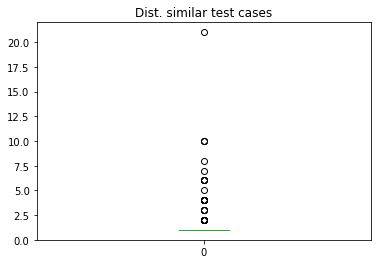

                0
count  242.000000
mean     1.574380
std      1.933716
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     21.000000



In [95]:
# Plot distribution of number of test cases in clusters/groups
plt.figure()
pd.DataFrame(list_number_elements).plot.box()
plt.title('Dist. similar test cases')
plt.show()
print(pd.DataFrame(list_number_elements).describe(), end='\n\n')

### Evaluate baseline 1

In [286]:
file_name = 'results_baseline_1/baseline_1_similar_test_cases.txt'
input_file = open(file_name, 'r')

In [287]:
# Read groups of similar test cases from baseline 1
baseline_appr_dict = {}
for line in input_file:
    case_key = line.split(':')[0].strip()
    cluster_id = line.split(':')[1].strip().replace('\n', '')
    baseline_appr_dict[case_key] = cluster_id

In [289]:
# Declare and initialize variables to compute F-score
TP = 0
FP = 0
TN = 0
FN = 0

In [290]:
# Iterate through list of steps to evaluate
for i in range(len(test_cases_to_evaluate_list)-1):
    for j in range(i+1, len(test_cases_to_evaluate_list)):
        case_key_1 = test_cases_to_evaluate_list[i]
        case_key_2 = test_cases_to_evaluate_list[j]
        
        # true positive case
        if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (baseline_appr_dict[case_key_1] == baseline_appr_dict[case_key_2]):
            TP += 1
            
        # false positive case
        elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (baseline_appr_dict[case_key_1] == baseline_appr_dict[case_key_2]):
            FP += 1
            
        # false negative case
        elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (baseline_appr_dict[case_key_1] != baseline_appr_dict[case_key_2]):
            FN += 1
            
        # true negative case
        elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (baseline_appr_dict[case_key_1] != baseline_appr_dict[case_key_2]):
            TN += 1

In [291]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("Precision = ", precision)
print("Recall = ", recall)

Precision =  0.9942857142857143
Recall =  0.3107142857142857


In [292]:
f_score = (2 * precision * recall) / (precision + recall)
print("F-score = ", f_score)

F-score =  0.473469387755102


### Evaluate baseline 2

In [293]:
file_name = 'results_baseline_2/baseline_2_similar_test_cases.txt'
input_file = open(file_name, 'r')

In [294]:
# Read groups of similar test cases from baseline 2
baseline_2_appr_dict = {}
for line in input_file:
    case_key = line.split(':')[0].strip()
    cluster_id = line.split(':')[1].strip().replace('\n', '')
    baseline_2_appr_dict[case_key] = cluster_id

In [296]:
# Declare and initialize variables to compute F-score
TP = 0
FP = 0
TN = 0
FN = 0

In [297]:
# Iterate through list of steps to evaluate
for i in range(len(test_cases_to_evaluate_list)-1):
    for j in range(i+1, len(test_cases_to_evaluate_list)):
        case_key_1 = test_cases_to_evaluate_list[i]
        case_key_2 = test_cases_to_evaluate_list[j]
        
        # true positive case
        if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (baseline_2_appr_dict[case_key_1] == baseline_2_appr_dict[case_key_2]):
            TP += 1
            
        # false positive case
        elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (baseline_2_appr_dict[case_key_1] == baseline_2_appr_dict[case_key_2]):
            FP += 1
            
        # false negative case
        elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (baseline_2_appr_dict[case_key_1] != baseline_2_appr_dict[case_key_2]):
            FN += 1
            
        # true negative case
        elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (baseline_2_appr_dict[case_key_1] != baseline_2_appr_dict[case_key_2]):
            TN += 1

In [298]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("Precision = ", precision)
print("Recall = ", recall)

Precision =  0.5
Recall =  0.0017857142857142857


In [299]:
f_score = (2 * precision * recall) / (precision + recall)
print("F-score = ", f_score)

F-score =  0.0035587188612099642


### Evaluate Technique 1 - simple overlap metric

In [40]:
overlap_thresholds = [np.around(x, 2) for x in np.arange(0.1, 1.05, 0.05)]

In [41]:
f_score_list_overlap = list()
for threshold in overlap_thresholds:
    file_name = 'test_case_similarity/results_approach_1/approach_1_similar_test_cases_' + str(threshold) + '.txt'
    input_file = open(file_name, 'r')
    
    # Read groups of similar test cases from approach 1
    approach_1_appr_dict = {}
    for line in input_file:
        case_key = line.split(':')[0].strip()
        cluster_id = line.split(':')[1].strip().replace('\n', '')
        approach_1_appr_dict[case_key] = cluster_id
        
    # Declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Iterate through list of steps to evaluate
    for i in range(len(test_cases_to_evaluate_list)-1):
        for j in range(i+1, len(test_cases_to_evaluate_list)):
            case_key_1 = test_cases_to_evaluate_list[i]
            case_key_2 = test_cases_to_evaluate_list[j]

            # true positive case
            if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                TP += 1

            # false positive case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                FP += 1

            # false negative case
            elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                FN += 1

            # true negative case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                TN += 1
                
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print("Precision = ", precision)
    print("Recall = ", recall)
    
    f_score = (2 * precision * recall) / (precision + recall)
    print("F-score = ", f_score)
    f_score_list_overlap.append(f_score)
    input_file.close()

Precision =  0.11020498126515318
Recall =  0.8928571428571429
F-score =  0.19619383951343927
Precision =  0.10015772870662461
Recall =  0.6803571428571429
F-score =  0.17461044912923923
Precision =  0.18235294117647058
Recall =  0.7196428571428571
F-score =  0.29097472924187723
Precision =  0.26957070707070707
Recall =  0.7625
F-score =  0.3983208955223881
Precision =  0.29298642533936653
Recall =  0.925
F-score =  0.4450171821305842
Precision =  0.3477051460361613
Recall =  0.8928571428571429
F-score =  0.5005005005005005
Precision =  0.5571273122959739
Recall =  0.9142857142857143
F-score =  0.6923597025016903
Precision =  0.5795964125560538
Recall =  0.9232142857142858
F-score =  0.7121212121212122
Precision =  0.5802469135802469
Recall =  0.9232142857142858
F-score =  0.7126119917298416
Precision =  0.7040816326530612
Recall =  0.8625
F-score =  0.7752808988764046
Precision =  0.7511664074650077
Recall =  0.8625
F-score =  0.8029925187032418
Precision =  0.7523510971786834
Recall =

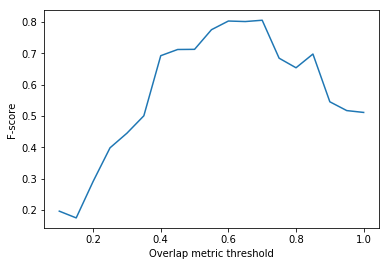

In [43]:
# Plot how F-score changes with different thresholds
plt.plot(overlap_thresholds, f_score_list_overlap)
plt.ylabel('F-score')
plt.xlabel('Overlap metric threshold')
plt.show()

In [44]:
# Print max f-score
max(f_score_list_overlap)

0.8054794520547944

In [45]:
# Get index os max f-score
f_score_list_overlap.index(max(f_score_list_overlap))

12

In [46]:
# Get optimal threshold
overlap_thresholds[12]

0.7

In [52]:
# Save data to generate plots in R
file_name = 'test_case_similarity_plots/approach_1_thresholds.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in overlap_thresholds]))
output_file.close()

file_name = 'test_case_similarity_plots/approach_1_f_score_list.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in f_score_list_overlap]))
output_file.close()

### Evaluate Technique 2 - Jaccard index

In [53]:
similarity_thresholds = [np.around(x, 2) for x in np.arange(0.1, 1.05, 0.05)]

In [54]:
f_score_list_jaccard = list()
for threshold in similarity_thresholds:
    file_name = 'test_case_similarity/results_approach_2/approach_2_similar_test_cases_' + str(threshold) + '.txt'
    input_file = open(file_name, 'r')
    
    # Read groups of similar test cases from approach 1
    approach_1_appr_dict = {}
    for line in input_file:
        case_key = line.split(':')[0].strip()
        cluster_id = line.split(':')[1].strip().replace('\n', '')
        approach_1_appr_dict[case_key] = cluster_id
        
    # Declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Iterate through list of steps to evaluate
    for i in range(len(test_cases_to_evaluate_list)-1):
        for j in range(i+1, len(test_cases_to_evaluate_list)):
            case_key_1 = test_cases_to_evaluate_list[i]
            case_key_2 = test_cases_to_evaluate_list[j]

            # true positive case
            if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                TP += 1

            # false positive case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                FP += 1

            # false negative case
            elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                FN += 1

            # true negative case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                TN += 1
                
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print("Precision = ", precision)
    print("Recall = ", recall)
    
    f_score = (2 * precision * recall) / (precision + recall)
    print("F-score = ", f_score)
    f_score_list_jaccard.append(f_score)
    input_file.close()

Precision =  0.08675708017550858
Recall =  0.7767857142857143
F-score =  0.1560818083961249
Precision =  0.14372392870686387
Recall =  0.6767857142857143
F-score =  0.2370972786987801
Precision =  0.19930340557275542
Recall =  0.9196428571428571
F-score =  0.3276081424936387
Precision =  0.2839237057220708
Recall =  0.9303571428571429
F-score =  0.43507306889352815
Precision =  0.41694078947368424
Recall =  0.9053571428571429
F-score =  0.570945945945946
Precision =  0.5258264462809917
Recall =  0.9089285714285714
F-score =  0.6662303664921465
Precision =  0.5374868004223865
Recall =  0.9089285714285714
F-score =  0.6755142667551426
Precision =  0.6111111111111112
Recall =  0.9035714285714286
F-score =  0.729106628242075
Precision =  0.6044098573281452
Recall =  0.8321428571428572
F-score =  0.7002253944402704
Precision =  0.7391304347826086
Recall =  0.7892857142857143
F-score =  0.7633851468048358
Precision =  0.7833333333333333
Recall =  0.7553571428571428
F-score =  0.7690909090909

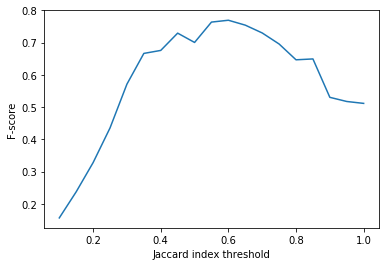

In [55]:
# Plot how F-score changes with different thresholds
plt.plot(similarity_thresholds, f_score_list_jaccard)
plt.ylabel('F-score')
plt.xlabel('Jaccard index threshold')
plt.show()

In [56]:
# Get max f-score
max(f_score_list_jaccard)

0.769090909090909

In [57]:
# Get index of max f-score
f_score_list_jaccard.index(max(f_score_list_jaccard))

10

In [58]:
# Get optimal threshold
similarity_thresholds[10]

0.6

In [59]:
# Save data to generate plots in R
file_name = 'test_case_similarity_plots/approach_2_thresholds.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in similarity_thresholds]))
output_file.close()

file_name = 'test_case_similarity_plots/approach_2_f_score_list.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in f_score_list_jaccard]))
output_file.close()

### Evaluate Technique 3 - cosine similarity using numeric vector

In [60]:
similarity_thresholds = [np.around(x, 2) for x in np.arange(0.1, 1.05, 0.05)]

In [61]:
f_score_list_numeric = list()
for threshold in similarity_thresholds:
    file_name = 'test_case_similarity/results_approach_3/approach_3_similar_test_cases_' + str(threshold) + '.txt'
    input_file = open(file_name, 'r')
    
    # Read groups of similar test cases from approach 1
    approach_1_appr_dict = {}
    for line in input_file:
        case_key = line.split(':')[0].strip()
        cluster_id = line.split(':')[1].strip().replace('\n', '')
        approach_1_appr_dict[case_key] = cluster_id
        
    # Declare and initialize variables to compute F-score
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Iterate through list of steps to evaluate
    for i in range(len(test_cases_to_evaluate_list)-1):
        for j in range(i+1, len(test_cases_to_evaluate_list)):
            case_key_1 = test_cases_to_evaluate_list[i]
            case_key_2 = test_cases_to_evaluate_list[j]

            # true positive case
            if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                TP += 1

            # false positive case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] == approach_1_appr_dict[case_key_2]):
                FP += 1

            # false negative case
            elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                FN += 1

            # true negative case
            elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_1_appr_dict[case_key_1] != approach_1_appr_dict[case_key_2]):
                TN += 1
                
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print("Precision = ", precision)
    print("Recall = ", recall)
    
    f_score = (2 * precision * recall) / (precision + recall)
    print("F-score = ", f_score)
    f_score_list_numeric.append(f_score)
    input_file.close()

Precision =  0.07225752970433821
Recall =  0.9339285714285714
F-score =  0.13413695819440882
Precision =  0.09327217125382263
Recall =  0.7625
F-score =  0.1662125340599455
Precision =  0.10543478260869565
Recall =  0.8660714285714286
F-score =  0.187984496124031
Precision =  0.12068034557235421
Recall =  0.7982142857142858
F-score =  0.20966228893058161
Precision =  0.1349036402569593
Recall =  0.7875
F-score =  0.23034734917733088
Precision =  0.15015115888478334
Recall =  0.7982142857142858
F-score =  0.2527565733672604
Precision =  0.1862273232136246
Recall =  0.8982142857142857
F-score =  0.3084943268935909
Precision =  0.25249003984063745
Recall =  0.9053571428571429
F-score =  0.39485981308411217
Precision =  0.2778993435448578
Recall =  0.9071428571428571
F-score =  0.42546063651591287
Precision =  0.3833718244803695
Recall =  0.8892857142857142
F-score =  0.535771920387305
Precision =  0.5232678386763185
Recall =  0.9035714285714286
F-score =  0.6627373935821873
Precision =  0

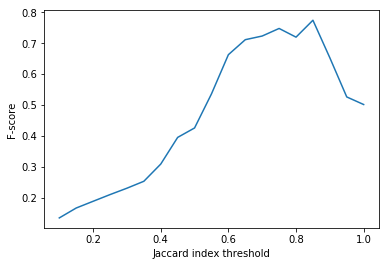

In [62]:
# Plot how F-score changes with different thresholds
plt.plot(similarity_thresholds, f_score_list_numeric)
plt.ylabel('F-score')
plt.xlabel('Jaccard index threshold')
plt.show()

In [63]:
# Get max f-score
max(f_score_list_numeric)

0.7742594484167519

In [64]:
# Get index of max f-score
f_score_list_numeric.index(max(f_score_list_numeric))

15

In [65]:
# Get optimal threshold
similarity_thresholds[15]

0.85

In [66]:
# Save data to generate plots in R
file_name = 'test_case_similarity_plots/approach_3_thresholds.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in similarity_thresholds]))
output_file.close()

file_name = 'test_case_similarity_plots/approach_3_f_score_list.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in f_score_list_numeric]))
output_file.close()

### Evaluate Technique 4 - cosine similarity using numeric vector plus test case name embedding

In [18]:
weight_list = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
threshold_list = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

In [ ]:
array_labels = list()
f_score_list = list()

# Search for the optimal weight (between test step cluster similarity and test case name embedding similarity) and threshold
for weight in weight_list:
    for threshold in threshold_list:
        file_name = 'test_case_similarity/results_approach_3_plus_name_embed/approach_3_plus_name_embed_' + str(weight) + '_' + str(threshold) + '.txt'
        array_labels.append(str(weight) + '_' + str(threshold))
        input_file = open(file_name, 'r')
        
        # Read groups of similar test cases from approach 
        approach_3_plus_dict = {}
        for line in input_file:
            case_key = line.split(':')[0].strip()
            cluster_id = line.split(':')[1].strip().replace('\n', '')
            approach_3_plus_dict[case_key] = cluster_id
        print(len(approach_3_plus_dict))
        
        # Declare and initialize variables to compute F-score
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        # Iterate through list of steps to evaluate
        for i in range(len(test_cases_to_evaluate_list)-1):
            for j in range(i+1, len(test_cases_to_evaluate_list)):
                case_key_1 = test_cases_to_evaluate_list[i]
                case_key_2 = test_cases_to_evaluate_list[j]

                # true positive case
                if (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_3_plus_dict[case_key_1] == approach_3_plus_dict[case_key_2]):
                    TP += 1

                # false positive case
                elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_3_plus_dict[case_key_1] == approach_3_plus_dict[case_key_2]):
                    FP += 1

                # false negative case
                elif (test_case_ground_truth_dict[case_key_1] == test_case_ground_truth_dict[case_key_2]) and (approach_3_plus_dict[case_key_1] != approach_3_plus_dict[case_key_2]):
                    FN += 1

                # true negative case
                elif (test_case_ground_truth_dict[case_key_1] != test_case_ground_truth_dict[case_key_2]) and (approach_3_plus_dict[case_key_1] != approach_3_plus_dict[case_key_2]):
                    TN += 1
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f_score = (2 * precision * recall) / (precision + recall)
        f_score_list.append(f_score)

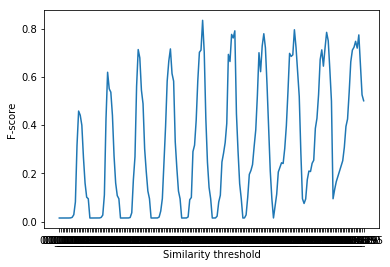

In [21]:
# Plot how F-score changes with different thresholds and weights
plt.plot(array_labels, f_score_list)
plt.ylabel('F-score')
plt.xlabel('Similarity threshold')
plt.show()

In [75]:
# Get max f-score
max(f_score_list)

0.8346613545816733

In [76]:
# Get index of max f-score
f_score_list.index(max(f_score_list))

89

In [77]:
# Get optimal weight and threshold
array_labels[89]

'0.5_0.75'

In [85]:
# Save data to generate plots in R
file_name = 'test_case_similarity_plots/approach_3_plus_name_thresholds.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in similarity_thresholds]))
output_file.close()

file_name = 'test_case_similarity_plots/approach_3_plus_name_f_score_list.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in f_score_list[76:95]]))
output_file.close()

In [24]:
# Save data to generate plots in R - full plot
file_name = 'test_case_similarity_plots/approach_3_plus_name_thresholds_full.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in array_labels]))
output_file.close()

file_name = 'test_case_similarity_plots/approach_3_plus_name_f_score_list_full.txt'
output_file = open(file_name, 'w')
output_file.write(' '.join([str(x) for x in f_score_list]))
output_file.close()

### 3D plot (WIP)

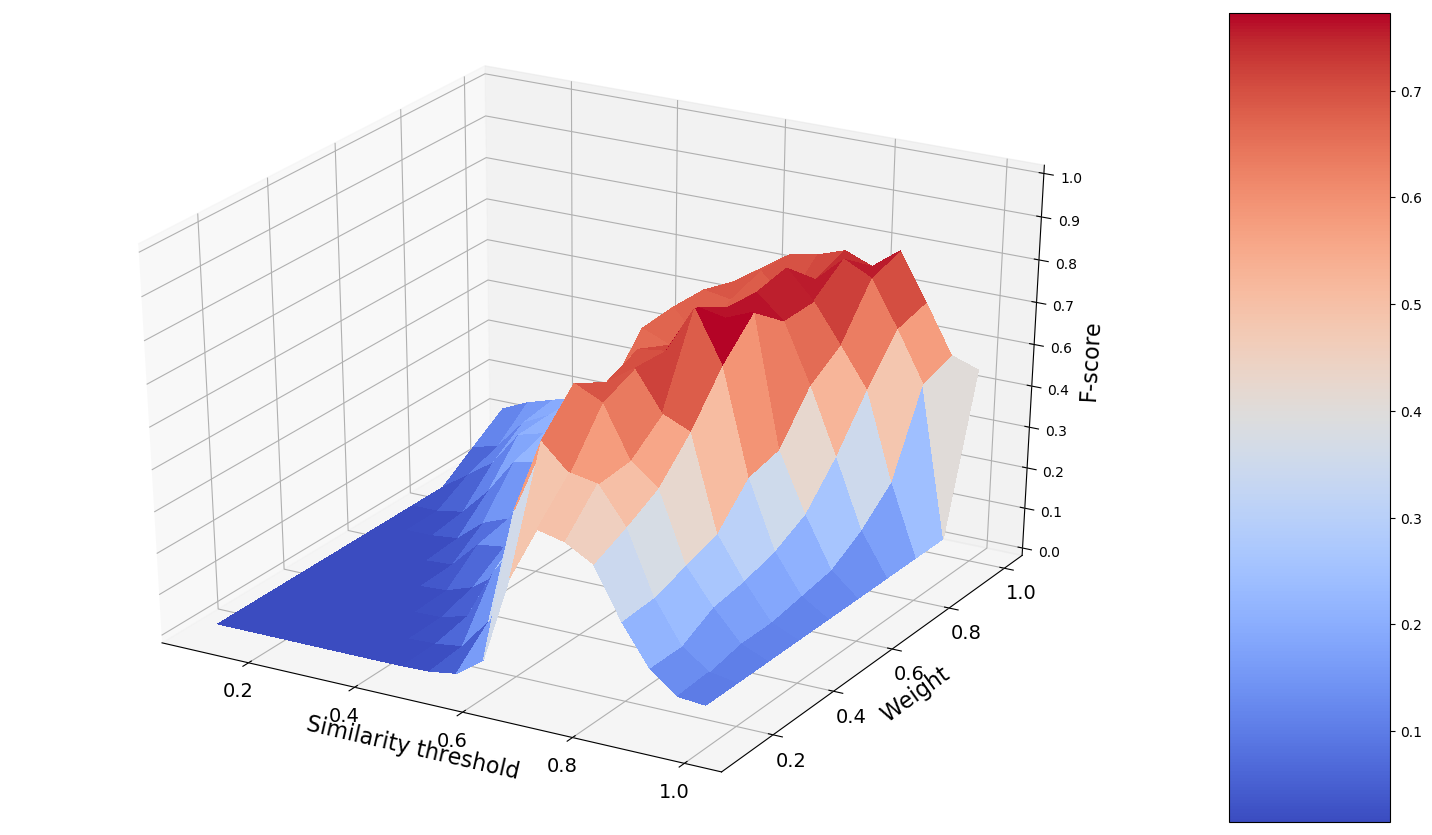

In [116]:
%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

matplotlib.rcParams.update({'font.size': 22})
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig = plt.figure()
ax = fig.gca(projection='3d')
X = threshold_list_backup 
Y = weight_list_backup
X, Y = np.meshgrid(X, Y)
Z = np.reshape(f_score_list, (10, 19))

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

ax.set_xlabel('Similarity threshold', fontsize=16)
ax.set_ylabel('Weight', fontsize=16)
ax.set_zlabel('F-score', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a color bar which maps values to colors
fig.colorbar(surf,  aspect=5)

fig.set_size_inches(18.5, 10.5)
plt.show()
fig.savefig('test_case_similarity_plots/3d_plot.pdf', dpi=100)